<a href="https://colab.research.google.com/github/porygon-tech/ECO/blob/main/demos/The_Effect_of_Polygenic_Adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pickle5
!git clone https://github.com/porygon-tech/ECO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'ECO'...
remote: Enumerating objects: 319, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 319 (delta 51), reused 73 (delta 22), pack-reused 200
Receiving objects: 100% (319/319), 4.68 MiB | 32.59 MiB/s, done.
Resolving deltas: 100% (133/133), done.


In [1]:
from scipy.special import comb  
import numpy as np
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit

def bindist(n,k,p=0.5):
    return comb(n,k)*p**k*(1-p)**(n-k)

def showfunc(f,xlim=(-5,5),definition=100, **kwargs):
            x= np.linspace(xlim[0],xlim[1],definition)
            fig = plt.figure(); ax = fig.add_subplot(111)
            ax.plot(x,f(x,**kwargs))
            plt.show()
            
def showlist(l, distbins=False):
            fig = plt.figure(); ax = fig.add_subplot(111)
            ax.plot(np.arange(len(l)),list(l))
            plt.show()

def showdata(mat, color='magma', symmetry=False):
    mat = np.copy(mat)
    if symmetry:
        top = np.max([np.abs(np.nanmax(mat)),np.abs(np.nanmin(mat))])
        plt.imshow(mat.astype('float32'), interpolation='none', cmap='seismic',vmax=top,vmin=-top)
    else:
        plt.imshow(mat.astype('float32'), interpolation='none', cmap=color)
    plt.colorbar()
    plt.show()
    
def augment(x,a=10,b=5):
    return 1-a**(-b*x)

In [9]:

from os import chdir
from pathlib import Path
import pickle5
import bz2
chdir('/content/ECO')
root = Path(".")
obj_path = root / 'data/obj'

In [11]:
n=100
nstates=n+1
filename='oc_tensor_' + str(n) + '.obj'
with bz2.BZ2File(obj_path / filename, 'rb') as f:
	oc_tensor = pickle5.load(f)

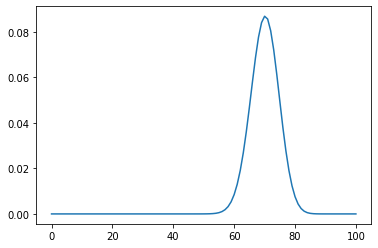

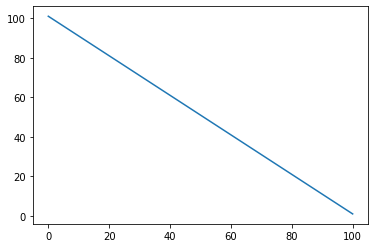

In [13]:
#POPULATION INITIALISATION
#------------------------
skw=0.7
ntimesteps = 200

def f(i):
    return 1+n-i
    #return 2**(-i/2)
    #return n**2-i**2
    #alpha=0.001; m=1/4*n
    #return np.exp(-alpha*(i-m)**2)

v = np.zeros((ntimesteps, nstates,1))
l = np.zeros((nstates,1))
for i in range(nstates):
    v[0,i] = bindist(n,i,skw)
    
for i in range(nstates):
    l[i] = f(i)

#------------------------
showlist(v[0])
showlist(l)

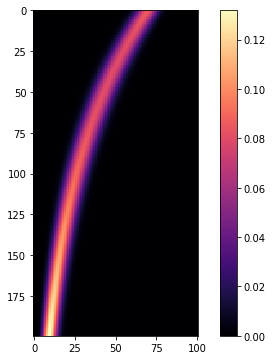

In [67]:
#%% STANDARD RUN

for t in range(1,ntimesteps):
    w = v[t-1]*l
    v[t] = ((w.T @ oc_tensor @ w) / w.sum()**2)[:,0]

#showdata(v[...,0])

%matplotlib inline

fig = plt.figure(figsize=(8,6)); ax = fig.add_subplot(111)
#div = make_axes_locatable(ax)
#cax = div.append_axes('right', '5%', '5%')
#cax = plt.axes([0.85, 0.1, 0.075, 0.8]
imsh = ax.imshow(v[...,0], interpolation='none', cmap='magma')
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.resizable = True
fig.colorbar(imsh)
plt.show()

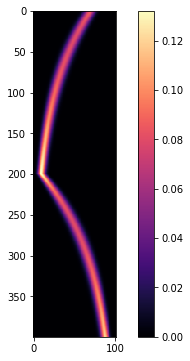

In [68]:
#%% AFTER A CHANGE IN ENVIRONMENTAL SELECTION
v2 = np.zeros((ntimesteps, nstates,1))
l2 = np.flip(l)

#showlist(v[-1])
v2[0] = v[-1]
for t in range(1,ntimesteps):
    w2 = v2[t-1]*l2
    v2[t] = ((w2.T @ oc_tensor @ w2) / w2.sum()**2)[:,0]

#showdata(np.append(v,v2,axis=0)[...,0])
fig = plt.figure(figsize=(8,6)); ax = fig.add_subplot(111)
imsh = ax.imshow(np.append(v,v2,axis=0)[...,0], interpolation='none', cmap='magma')
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.resizable = True
fig.colorbar(imsh)
plt.show()

# New Section

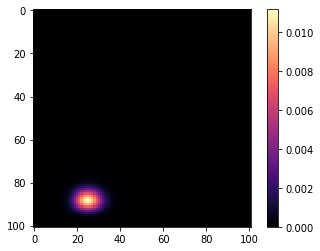

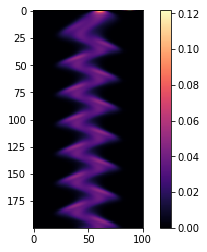

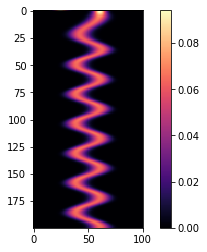

In [21]:


s1=v[np.random.randint(ntimesteps)]
s2=v[np.random.randint(ntimesteps)]

skw_1, skw_2 = np.random.rand(2)

for i in range(nstates):
    s1[i] = bindist(n,i,skw_1)
    s2[i] = bindist(n,i,skw_2)

'''
fig = plt.figure(); ax = fig.add_subplot(111)
ax.plot(np.arange(nstates),s1)
ax.plot(np.arange(nstates),s2)
plt.show()
'''
m_comb_probs=s1@s2.T
showdata(m_comb_probs)
#%% 

v_s1 = np.zeros((ntimesteps, nstates,1))
v_s2 = np.zeros((ntimesteps, nstates,1))
l_s1 = np.zeros((ntimesteps, nstates,1))
l_s2 = np.zeros((ntimesteps, nstates,1))

l_s1[0] = s2
l_s2[0] = s1

v_s1[0] = s1
v_s2[0] = s2

for t in range(1,ntimesteps):
    
    w_s1 = v_s1[t-1]*l_s1[t-1]
    w_s2 = v_s2[t-1]*l_s2[t-1]
    v_s1[t] = ((w_s1.T @ oc_tensor @ w_s1) / w_s1.sum()**2)[:,0]
    v_s2[t] = ((w_s2.T @ oc_tensor @ w_s2) / w_s2.sum()**2)[:,0]
    #l_s1[t] = np.max(v_s2[t])-v_s2[t]
    #l_s2[t] = np.max(v_s1[t])-v_s1[t]
    l_s1[t] = 1/(1+100*v_s2[t])#*1/(1+1000*v_s1[t])
    #l_s2[t] = 1/(1+10000*v_s1[t])#*1/(1+10000*v_s2[t])
    l_s2[t] = v_s1[t]*1/(1+100*v_s2[t])

#%%
showdata(v_s1[...,0])
showdata(v_s2[...,0])


In [82]:
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import copy
my_cmap = copy.copy(plt.cm.get_cmap('magma')) # copy the default cmap
my_cmap.set_bad((0,0,0))

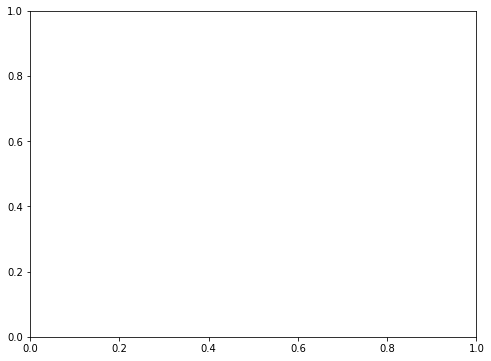

In [95]:
fig = plt.figure(figsize=(8,6)); ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
#cax = div.append_axes('right', '5%', '5%')
def frame(t):
    ax.clear()
    #plot=ax.imshow(l_matrix[:,:,w].astype('float32'), interpolation='none', cmap=my_cmap,vmax=1,vmin=10e-20,norm=LogNorm(vmin=0, vmax=1)) #
    ax.set_ylim(0,0.1)
    plot=ax.bar(np.arange(nstates),v_s1[t,:,0],width=1,alpha=0.5)
    plot+=ax.bar(np.arange(nstates),v_s2[t,:,0],width=1,alpha=0.5)
    #fig.colorbar(plot,ax=ax,cax=cax)
    return plot

In [96]:
anim = animation.FuncAnimation(fig, frame, frames=100, blit=False, repeat=True)

In [97]:
anim

In [ ]:
fig = plt.figure(figsize=(8,6)); ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
def frame(t):
    ax.clear()
    plot=ax.imshow(v_s1[t]@v_s1[t].T, interpolation='none', cmap='magma',vmax=0.005,vmin=0) #
    fig.colorbar(plot,ax=ax,cax=cax)
    return plot

In [90]:
anim = animation.FuncAnimation(fig, frame, frames=100, blit=False, repeat=True)

In [98]:
anim